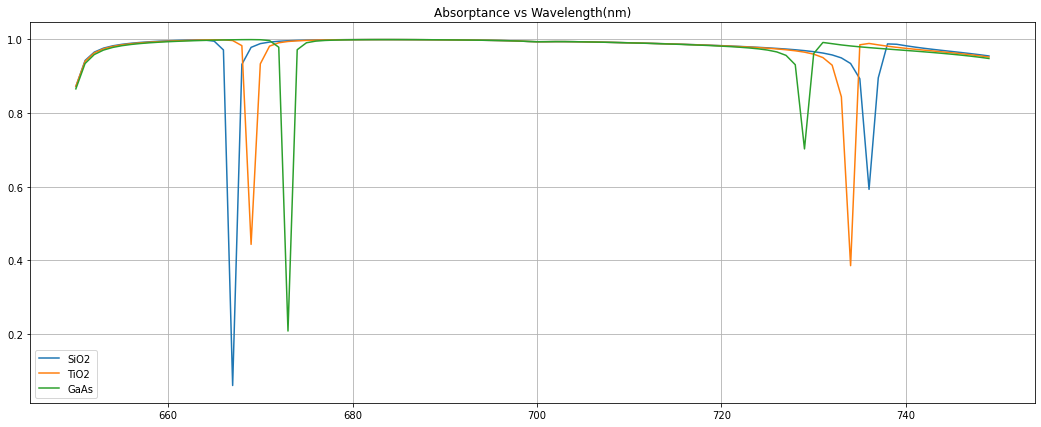

In [180]:
import numpy as np
import math
import matplotlib.pyplot as plt

lowRefractiveIndex = 1.45
highRefractiveIndex = 4.234
mediumRefractiveIndex = 1.45
airRefractiveIndex = 1.000273
subRefractiveIndex = 1.52
crRefractiveIndex = complex(3.073,-3.383)
defectRefractiveIndex = 1.45
glassRefractiveIndex = 1.458

designWavelength = 700.0
layerThicknessDividerCoefficent = 4.0
lowLayerThickness = designWavelength / (layerThicknessDividerCoefficent * lowRefractiveIndex)
highLayerThickness = designWavelength / (layerThicknessDividerCoefficent * highRefractiveIndex)
mediumLayerThickness = designWavelength / (layerThicknessDividerCoefficent * mediumRefractiveIndex)
airLayerThickness = designWavelength / (layerThicknessDividerCoefficent * airRefractiveIndex)
subLayerThickness = designWavelength / (layerThicknessDividerCoefficent * subRefractiveIndex)
glassLayerThickness = designWavelength / (layerThicknessDividerCoefficent * glassRefractiveIndex)
crLayerThickness = 5.0
defectLayerThickness = designWavelength / (2.0 * defectRefractiveIndex)

totalSystemMatrix = np.ones((2, 2),dtype = complex)
n1Multip = n2Multip = 2
absorptance = []
reflectance = []
transmittance = []

absorptance_SiO2 = []
absorpttance_TiO2 = []
absorptance_GaAs = []

#Testing Purposes
totalTest = [] # totalTest = 1 = R + A + T
sequenceTestChooser = True # True:Fibonacci    False:Thue
sequenceTestWavelenthRangeChooser = range(650,750) if sequenceTestChooser == True  else range(400,1800)

def LayerMatrixCal(dynamicalMatrix, inverseDynamicalMatrix, TranslationalMatrix):
    return dynamicalMatrix.dot(TranslationalMatrix).dot(inverseDynamicalMatrix)

def DynamicalMatrixCal(refractiveIndex):
    dynamicalMatrix = np.ones((2, 2),dtype=complex)
    dynamicalMatrix[1][0] = refractiveIndex
    dynamicalMatrix[1][1] = -refractiveIndex
    return dynamicalMatrix

def InverseDynamicalMatrixCal(dynamicalMatrix):
    return np.linalg.inv(dynamicalMatrix)

def TranslationalMatrixCal(thickness, wavelength, refractiveIndex):
    translationalMatrix = np.zeros((2, 2),dtype = complex)
    phase = 2*math.pi*thickness*refractiveIndex/wavelength
    translationalMatrix[0][0] = complex(math.cos(phase.real)*math.exp(-1*phase.imag),math.sin(phase.real)*math.exp(-1*phase.imag))
    translationalMatrix[1][1] = complex(math.cos(phase.real)*math.exp(phase.imag),-1.0 * math.sin(phase.real)*math.exp(phase.imag))
    return translationalMatrix

def ReflectanceCal(totalSystemMatrix):
    return (abs(totalSystemMatrix[1][0]) / abs(totalSystemMatrix[0][0]))**2

def TransmittanceCal(totalSystemMatrix):
    return (subRefractiveIndex / airRefractiveIndex) * ((1 / abs(totalSystemMatrix[0][0]))**2)

def AbsorptanceCal(totalSystemMatrix):
    reflectance = ReflectanceCal(totalSystemMatrix)
    transmittance = TransmittanceCal(totalSystemMatrix)
    return (1.0 - reflectance - transmittance)

def TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1,n2,mcr):
    fifthFiboSequence = ml.dot(mh).dot(ml).dot(mh).dot(ml).dot(ml).dot(mh).dot(ml)
    leftStructMatrix = fifthFiboSequence
    for i in range(0,n1 - 1):
        leftStructMatrix = leftStructMatrix.dot(fifthFiboSequence)
    rightStructMatrix = fifthFiboSequence
    for k in range(0,n2 - 1):
        rightStructMatrix = rightStructMatrix.dot(fifthFiboSequence)
    return dairinv.dot(mcr).dot(leftStructMatrix).dot(mdef).dot(rightStructMatrix).dot(mh).dot(dsub)

def TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1):
    thueMorseSeqMatrix = (mh.dot(ml).dot(mmed).dot(ml).dot(mmed).dot(mh).dot(ml).dot(mmed)
        .dot(mh).dot(mh).dot(ml).dot(mmed).dot(ml).dot(mmed)
        .dot(mh).dot(mh).dot(ml).dot(mmed).dot(mh).dot(ml).dot(mmed).dot(ml).dot(mmed).dot(mh))
    structMatrix = thueMorseSeqMatrix
    for i in range(0, n1 - 1):
        structMatrix = structMatrix.dot(structMatrix)
    return dairinv.dot(structMatrix).dot(dglass)

for defectMaterialIndices in [1.45,2.17,3.8]:
    defectRefractiveIndex = defectMaterialIndices
    defectLayerThickness = designWavelength / (2.0 * defectRefractiveIndex)
    absorptance.clear()
    reflectance.clear()
    transmittance.clear()
    totalTest.clear()
    for wavelength in sequenceTestWavelenthRangeChooser:
        dl = DynamicalMatrixCal(lowRefractiveIndex)
        dlinv = InverseDynamicalMatrixCal(dl)
        pl = TranslationalMatrixCal(lowLayerThickness,wavelength,lowRefractiveIndex)
        ml = LayerMatrixCal(dl,dlinv,pl)
    
        dh = DynamicalMatrixCal(highRefractiveIndex)
        dhinv = InverseDynamicalMatrixCal(dh)
        ph = TranslationalMatrixCal(highLayerThickness,wavelength,highRefractiveIndex)
        mh = LayerMatrixCal(dh,dhinv,ph)
    
        dmed = DynamicalMatrixCal(mediumRefractiveIndex)
        dmedinv = InverseDynamicalMatrixCal(dmed)
        pmed = TranslationalMatrixCal(mediumLayerThickness,wavelength,mediumRefractiveIndex)
        mmed = LayerMatrixCal(dmed,dmedinv,pmed)
    
        dair = DynamicalMatrixCal(airRefractiveIndex)
        dairinv = InverseDynamicalMatrixCal(dair)
    
        dsub = DynamicalMatrixCal(subRefractiveIndex)
    
        ddef = DynamicalMatrixCal(defectRefractiveIndex)
        ddefinv = InverseDynamicalMatrixCal(ddef)
        pdef = TranslationalMatrixCal(defectLayerThickness,wavelength,defectRefractiveIndex)
        mdef = LayerMatrixCal(ddef,ddefinv,pdef)
    
        dcr = DynamicalMatrixCal(crRefractiveIndex)
        dcrinv = InverseDynamicalMatrixCal(dcr)
        pcr = TranslationalMatrixCal(crLayerThickness,wavelength,crRefractiveIndex)
        mcr = LayerMatrixCal(dcr,dcrinv,pcr)
    
        dglass = DynamicalMatrixCal(glassRefractiveIndex)
        
        if(sequenceTestChooser == True):
            #Coefficients For Fibonacci Sequence
            totalTest.append(AbsorptanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)) 
                + ReflectanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr))
                + TransmittanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
            absorptance.append(AbsorptanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
            reflectance.append(ReflectanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
            transmittance.append(TransmittanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
        else:
            #Coefficients For Thue-Morse Sequence
            totalTest.append(AbsorptanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)) 
                + ReflectanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip))
                + TransmittanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))
            absorptance.append(AbsorptanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))
            reflectance.append(ReflectanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))
            transmittance.append(TransmittanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))

    if(defectMaterialIndices == 1.45):
        absorptance_SiO2 = absorptance[:]
    elif(defectMaterialIndices == 2.17):
        absorpttance_TiO2 = absorptance[:]
    elif(defectMaterialIndices == 3.8):
        absorptance_GaAs = absorptance[:]



#for wavelength in sequenceTestWavelenthRangeChooser:
#    dl = DynamicalMatrixCal(lowRefractiveIndex)
#    dlinv = InverseDynamicalMatrixCal(dl)
#    pl = TranslationalMatrixCal(lowLayerThickness,wavelength,lowRefractiveIndex)
#    ml = LayerMatrixCal(dl,dlinv,pl)
#
#    dh = DynamicalMatrixCal(highRefractiveIndex)
#    dhinv = InverseDynamicalMatrixCal(dh)
#    ph = TranslationalMatrixCal(highLayerThickness,wavelength,highRefractiveIndex)
#    mh = LayerMatrixCal(dh,dhinv,ph)
#
#    dmed = DynamicalMatrixCal(mediumRefractiveIndex)
#    dmedinv = InverseDynamicalMatrixCal(dmed)
#    pmed = TranslationalMatrixCal(mediumLayerThickness,wavelength,mediumRefractiveIndex)
#    mmed = LayerMatrixCal(dmed,dmedinv,pmed)
#
#    dair = DynamicalMatrixCal(airRefractiveIndex)
#    dairinv = InverseDynamicalMatrixCal(dair)
#
#    dsub = DynamicalMatrixCal(subRefractiveIndex)
#
#    ddef = DynamicalMatrixCal(defectRefractiveIndex)
#    ddefinv = InverseDynamicalMatrixCal(ddef)
#    pdef = TranslationalMatrixCal(defectLayerThickness,wavelength,defectRefractiveIndex)
#    mdef = LayerMatrixCal(ddef,ddefinv,pdef)
#
#    dcr = DynamicalMatrixCal(crRefractiveIndex)
#    dcrinv = InverseDynamicalMatrixCal(dcr)
#    pcr = TranslationalMatrixCal(crLayerThickness,wavelength,crRefractiveIndex)
#    mcr = LayerMatrixCal(dcr,dcrinv,pcr)
#
#    dglass = DynamicalMatrixCal(glassRefractiveIndex)
#    
#    if(sequenceTestChooser == True):
#        #Coefficients For Fibonacci Sequence
#        totalTest.append(AbsorptanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)) 
#            + ReflectanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr))
#            + TransmittanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
#        absorptance.append(AbsorptanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
#        reflectance.append(ReflectanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
#        transmittance.append(TransmittanceCal(TotalSystemMatrixFibonacciCal(ml,mh,dairinv,mdef,dsub,n1Multip,n2Multip,mcr)))
#    else:
#        #Coefficients For Thue-Morse Sequence
#        totalTest.append(AbsorptanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)) 
#            + ReflectanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip))
#            + TransmittanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))
#        absorptance.append(AbsorptanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))
#        reflectance.append(ReflectanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))
#        transmittance.append(TransmittanceCal(TotalSystemMatrixThueMorseCal(ml,mh,mmed,dglass,dairinv,n1Multip)))







if(sequenceTestChooser == False):
    wavelength = np.arange(400,1800)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7))
    fig.suptitle('Triple Thue-Morse Array Structure Results at N = ' + str(n1Multip))
    ax1.plot(wavelength,reflectance)
    ax2.plot(wavelength,transmittance, 'tab:orange')
    ax3.plot(wavelength,absorptance, 'tab:green')
    ax4.plot(wavelength,totalTest, 'tab:red')
    ax1.title.set_text('Reflectance vs Wavelength(nm)')
    ax2.title.set_text('Transmittance vs Wavelength(nm)')
    ax3.title.set_text('Absorptance vs Wavelength(nm)')
    ax4.title.set_text('Total(R + A + T) vs Wavelength(nm)')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
else:
    #wavelength = np.arange(650,750)
    #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7))
    #fig.suptitle('Fifth Fibonacci Sequence Multilayer with Thinmetal at N = ' + str(n1Multip))
    #ax1.plot(wavelength,reflectance)
    #ax2.plot(wavelength,transmittance, 'tab:orange')
    #ax3.plot(wavelength,absorptance, 'tab:green')
    #ax4.plot(wavelength,totalTest, 'tab:red')
    #ax1.title.set_text('Reflectance vs Wavelength(nm)')
    #ax2.title.set_text('Transmittance vs Wavelength(nm)')
    #ax3.title.set_text('Absorptance vs Wavelength(nm)')
    #ax4.title.set_text('Total(R + A + T) vs Wavelength(nm)')
    #ax1.grid(True)
    #ax2.grid(True)
    #ax3.grid(True)
    #ax4.grid(True)
    
    wavelength = np.arange(650,750)
    plt.figure(figsize=(18,7))
    plt.title('Absorptance vs Wavelength(nm)')
    plt.plot(wavelength,absorptance_SiO2)
    plt.plot(wavelength,absorpttance_TiO2)
    plt.plot(wavelength,absorptance_GaAs)
    plt.legend(['SiO2','TiO2','GaAs'])
    plt.grid(True)
